In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from dateutil import parser
import holidays
from prophet import Prophet
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, roc_curve
from prophet.diagnostics import cross_validation,  performance_metrics
from prophet.plot import plot_plotly, plot_cross_validation_metric, plot_components_plotly, add_changepoints_to_plot, plot_yearly
from prophet.serialize import model_to_json, model_from_json
import itertools

In [2]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
#!unzip household_power_consumption.zip

In [3]:
pd.set_option("display.float_format", "{:.2f}".format)

In [4]:
# The ds (datestamp) column should be of a format expected by Pandas,
# ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)
del df['Sub_metering_1']
del df['Sub_metering_2']
del df['Sub_metering_3']
del df['Global_reactive_power']
del df['Voltage']
del df['Global_intensity']
df.rename(columns={'Global_active_power':'y'}, inplace = True)
df

/var/folders/37/_l5tpcds0ds80zc5hj8673lh0000gp/T/ipykernel_44449/1217904178.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)
/var/folders/37/_l5tpcds0ds80zc5hj8673lh0000gp/T/ipykernel_44449/1217904178.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True,low_memory=False)


,ds,y
0,2006-12-16 17:24:00,4.22
1,2006-12-16 17:25:00,5.36
2,2006-12-16 17:26:00,5.37
3,2006-12-16 17:27:00,5.39
4,2006-12-16 17:28:00,3.67
...,...,...
2075254,2010-11-26 20:58:00,0.95
2075255,2010-11-26 20:59:00,0.94
2075256,2010-11-26 21:00:00,0.94
2075257,2010-11-26 21:01:00,0.93


In [5]:
df.isna().sum()

ds        0
y     25979
dtype: int64

In [6]:
df.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
ds,2075259,2008-12-06 07:12:59.999994112,2006-12-16 17:24:00,2007-12-12 00:18:30,2008-12-06 07:13:00,2009-12-01 14:07:30,2010-11-26 21:02:00,NaN
y,2049280.00,1.09,0.08,0.31,0.60,1.53,11.12,1.06


In [7]:
df = df.fillna(df.shift(60*24*7))

In [8]:
df.isna().sum()

ds    0
y     3
dtype: int64

In [9]:
df = df.fillna(df.shift(60*24*7))

In [10]:
df.isna().sum()

ds    0
y     2
dtype: int64

In [11]:
df = df.fillna(df.shift(60*24))

In [12]:
df.isna().sum()

ds    0
y     0
dtype: int64

In [13]:
df.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
ds,2075259,2008-12-06 07:12:59.999994112,2006-12-16 17:24:00,2007-12-12 00:18:30,2008-12-06 07:13:00,2009-12-01 14:07:30,2010-11-26 21:02:00,NaN
y,2075259.00,1.09,0.08,0.31,0.60,1.53,11.12,1.06


In [14]:
# # Standardization
df["y"] = df["y"].apply(lambda x: x/60)


In [28]:
#Group by hours
df_H = df.resample('H', on="ds").mean()
df_H = df_H.reset_index(drop=False)
df_H.head()

,ds,y
0,2006-12-16 17:00:00,0.07
1,2006-12-16 18:00:00,0.06
2,2006-12-16 19:00:00,0.06
3,2006-12-16 20:00:00,0.05
4,2006-12-16 21:00:00,0.05


18:50:06 - cmdstanpy - INFO - Chain [1] start processing
18:50:06 - cmdstanpy - INFO - Chain [1] done processing


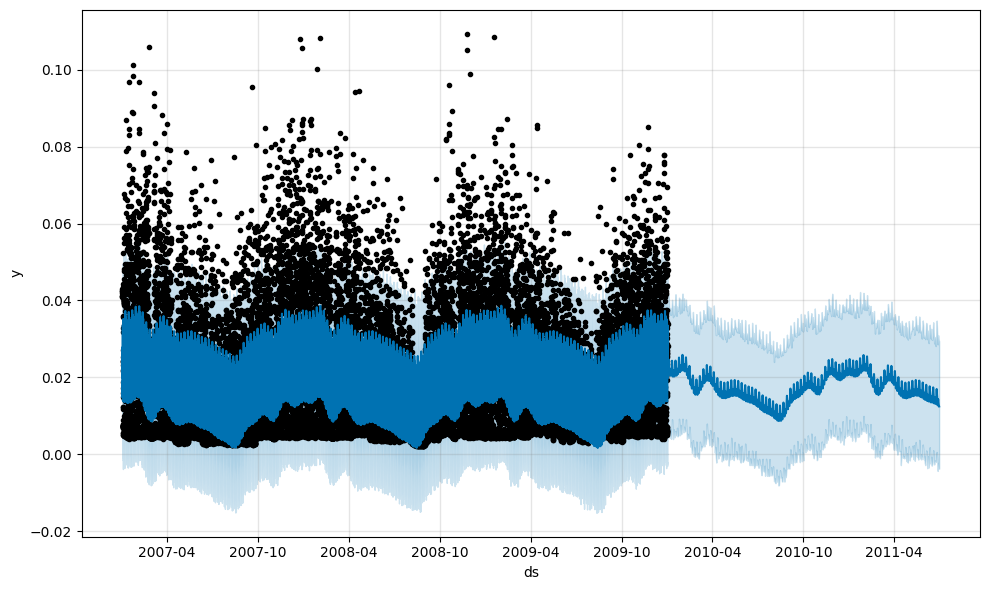

In [29]:
## MODEL HOLIDAYS


train_data = df_H[(df_H['ds'] >= '2007-01-01 00:00:00') & (df_H['ds'] < '2010-01-01 00:00:00')]
test_data = df_H[(df_H['ds'] >= '2010-01-01 00:00:00') & (df_H['ds'] < '2010-10-01 00:00:00')]


train_data_mean = train_data.groupby(train_data.ds.dt.to_period('W')).mean()
test_data_mean = test_data.groupby(test_data.ds.dt.to_period('W')).mean()


model_holidays = Prophet(seasonality_mode='multiplicative', # for our problem
               growth='flat',
               interval_width=0.8,                # 0.8 is default (experimenting)
               changepoint_prior_scale=0.01,      # (experimenting)
               holidays_prior_scale=0.01,         # (experimenting)
               seasonality_prior_scale=0.01,      # (experimenting)
               changepoint_range = 0.8)


model_holidays.add_country_holidays(country_name='FRA')
model_holidays.fit(train_data)

future_holidays = model_holidays.make_future_dataframe(periods=546, freq='D', include_history=True)


forecast_holidays = model_holidays.predict(future_holidays)
fig = model_holidays.plot(forecast_holidays)


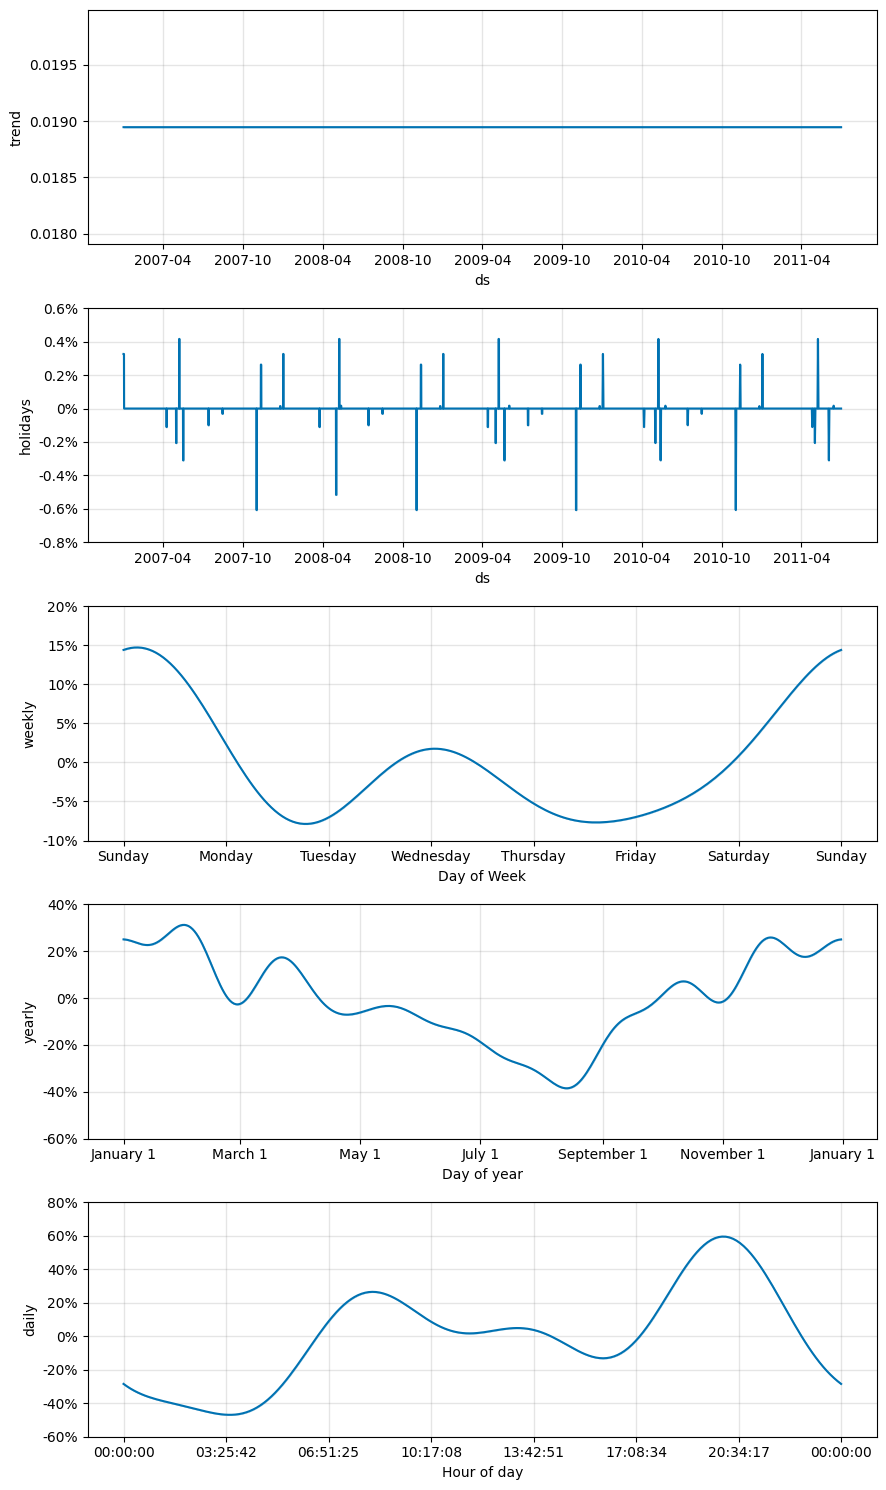

In [30]:
fig2 = model_holidays.plot_components(forecast_holidays)



### CROSS VALIDATION

In [31]:
cv_holidays = cross_validation(model_holidays,
                          horizon='90 days',
                         period='30 days',
                         initial='540 days', #initial = horizon x 3
                         parallel='processes')

18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing
18:50:26 - cmdstanpy - INFO - Chain [1] done processing
18:50:30 - cmdstanpy - INFO - Chain [1] start processing
18:50:30 - cmdstanpy - INFO - Chain [1]

In [32]:
cv_holidays_pm= performance_metrics(cv_holidays)
cv_holidays_pm.head()



,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.00,0.01,0.01,1.04,0.53,0.58,0.90
1,9 days 01:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.90
2,9 days 02:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.90
3,9 days 03:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.90
4,9 days 04:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.90


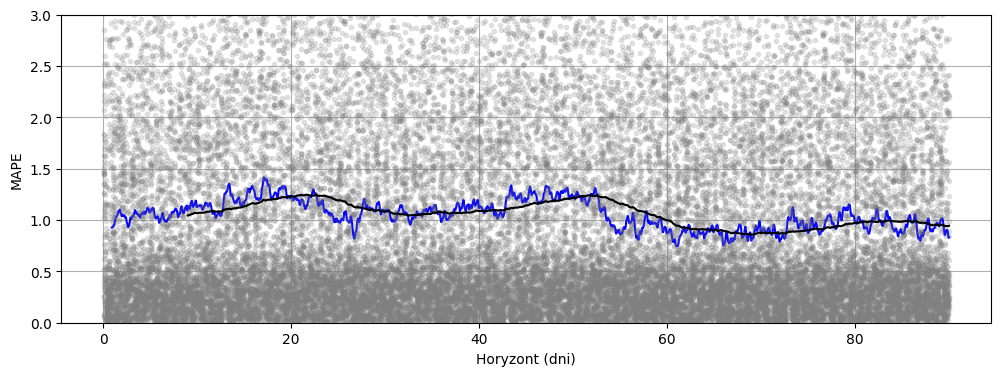

In [33]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
plot_cross_validation_metric(cv_holidays,
                             metric='mape',
                             rolling_window=.01,
                             color='blue',
                             ax=ax)
plot_cross_validation_metric(cv_holidays,
                             metric='mape',
                             rolling_window=.1,
                             color='black',
                             ax=ax)


plt.ylabel("MAPE") 
plt.xlabel('Horyzont (dni)') 
plt.ylim(0, 3)

plt.show()

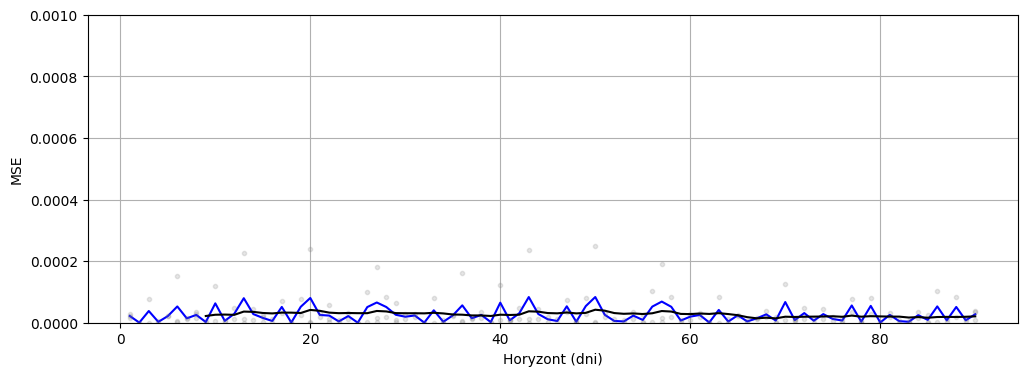

In [21]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plot_cross_validation_metric(cv_holidays,
                             metric='mse',
                             rolling_window=.01,
                             color='blue',
                             ax=ax)
plot_cross_validation_metric(cv_holidays,
                             metric='mse',
                             rolling_window=.1,
                             color='black',
                             ax=ax)
plt.ylabel("MSE") 
plt.xlabel('Horyzont (dni)') 
plt.ylim(0, 0.001)
plt.show()

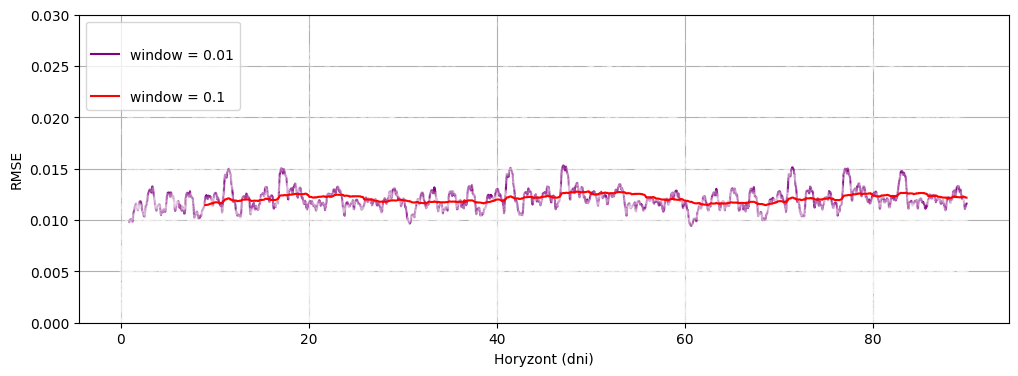

In [34]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plot_cross_validation_metric(cv_holidays,
                             metric='rmse',
                             rolling_window=0.01,
                             color='purple',
                             point_color = 'white',
                             ax=ax)
plot_cross_validation_metric(cv_holidays,
                             metric='rmse',
                             rolling_window=.1,
                             color='red',
                             point_color = 'white',
                             ax=ax)

plt.ylabel("RMSE") 
plt.xlabel('Horyzont (dni)') 
plt.ylim(0, 0.03)
plt.legend(['','window = 0.01','','window = 0.1'])

plt.show()


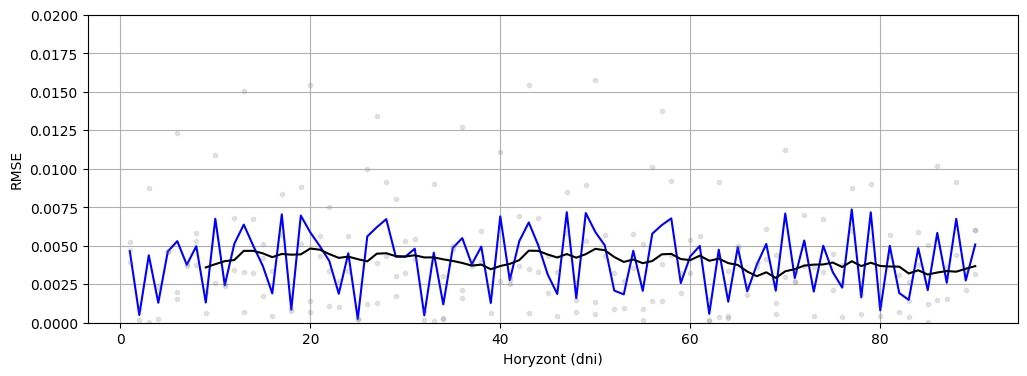

In [23]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plot_cross_validation_metric(cv_holidays,
                             metric='mae',
                             rolling_window=.01,
                             color='blue',
                             ax=ax)
plot_cross_validation_metric(cv_holidays,
                             metric='mae',
                             rolling_window=.1,
                             color='black',
                             ax=ax)

plt.ylabel("RMSE") 
plt.xlabel('Horyzont (dni)') 
plt.ylim(0, 0.02)

plt.show()

### HYPERPARAMETER TUNING

In [35]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmse = []  

for params in all_params:
    model_holidays = Prophet(**params).fit(train_data)  # Fit model with given params
    cv_holidays = cross_validation(model_holidays, 
                                 horizon='90 days', 
                                   period='30 days',
                                   initial='540 days',
                                   parallel="processes")
    cv_holidays_pm = performance_metrics(cv_holidays, rolling_window=1)
    rmse.append(cv_holidays_pm['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmse
print(tuning_results)


KeyboardInterrupt: 

In [36]:
best_params = all_params[np.argmin(rmse)]
print(best_params)

ValueError: attempt to get argmin of an empty sequence

18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing


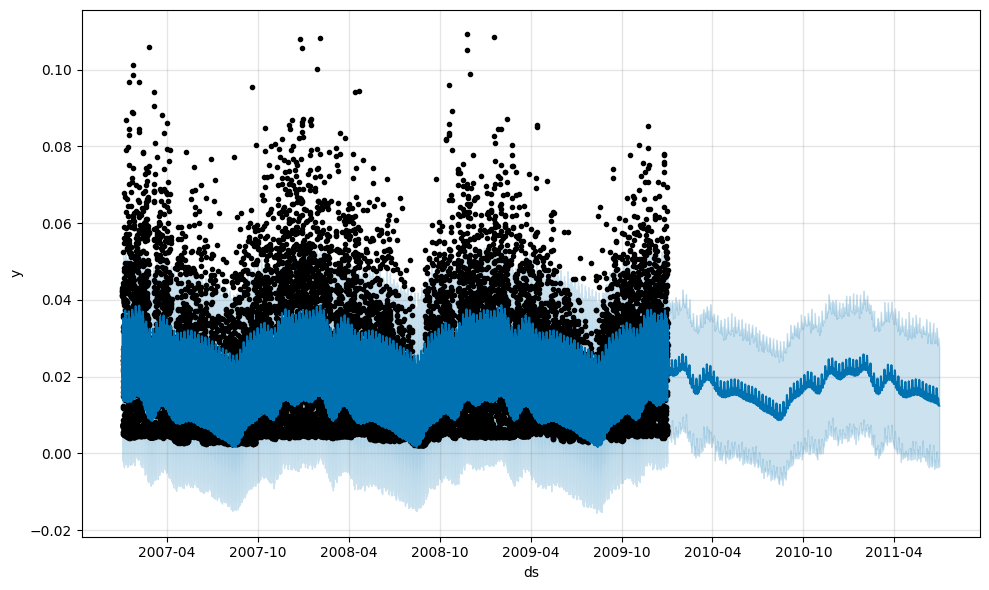

In [37]:
model_holidays2 = Prophet(seasonality_mode='multiplicative', 
               growth='flat',
               interval_width=0.8,                
               changepoint_prior_scale=0.001,      
               holidays_prior_scale=0.01,         
               seasonality_prior_scale=0.01,      
               changepoint_range = 0.85         
               )                                 

model_holidays2.add_country_holidays(country_name='FRA')
model_holidays2.fit(train_data)

future_holidays2 = model_holidays2.make_future_dataframe(periods=546, freq='D')

forecast_holidays2 = model_holidays2.predict(future_holidays2)
fig = model_holidays2.plot(forecast_holidays2)



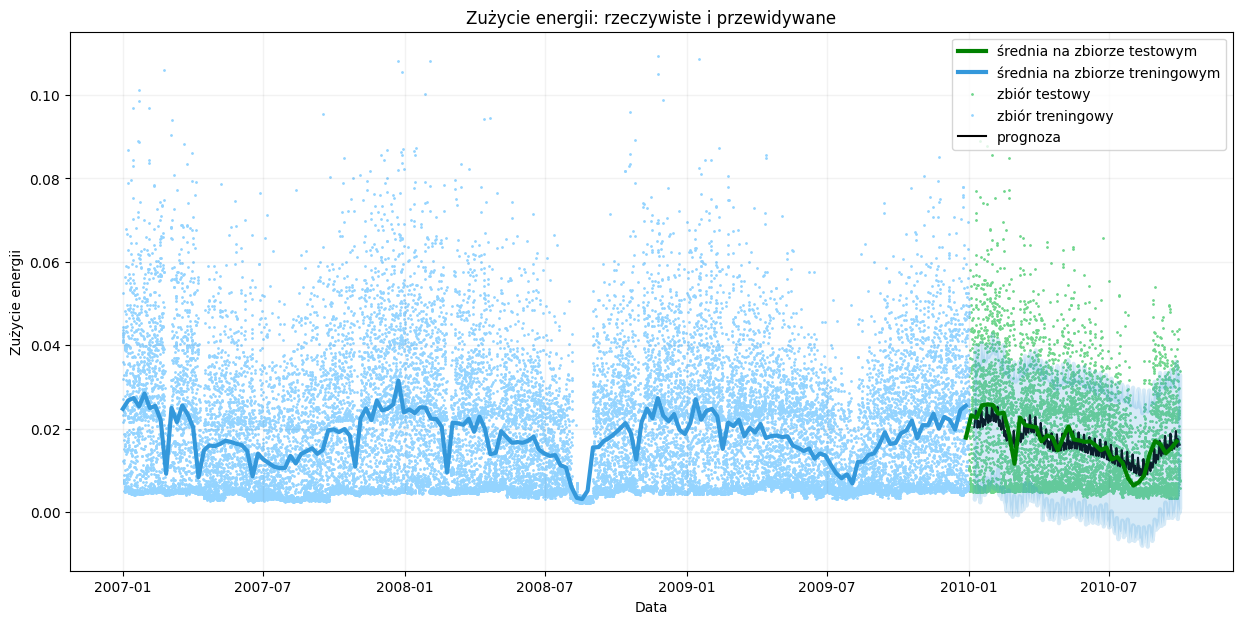

In [46]:

fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.plot(test_data_mean.index.to_timestamp(), test_data_mean.y, '-', linewidth=3, color='green', label = "średnia na zbiorze testowym", zorder = 4 ) 
plt.plot(train_data_mean.index.to_timestamp(), train_data_mean.y, '-', linewidth=3, color='#3498DB', label = "średnia na zbiorze treningowym", zorder = 4) 

plt.plot(test_data.ds, test_data.y, '.',markersize=2, color='#6fd68c', label = "zbiór testowy", zorder = 1)
plt.plot(train_data.ds, train_data.y, '.',markersize=2, color='#94d4ff', label = "zbiór treningowy", zorder= 1)
plt.plot(forecast_holidays2.ds[-540:-273], forecast_holidays2.yhat[-540:-273], color='black', label = "prognoza", zorder = 1)
plt.fill_between(forecast_holidays2.ds[-540:-273], forecast_holidays2.yhat_lower[-540:-273], forecast_holidays2.yhat_upper[-540:-273], linewidth=3, color=(52/255, 152/255, 219/255, 0.2))

plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Zużycie energii')
plt.title('Zużycie energii: rzeczywiste i przewidywane')
plt.xlabel('Data')
plt.legend()
plt.show()



In [39]:
cv_holidays2 = cross_validation(model_holidays2,
                         horizon='90 days',
                         period='30 days',
                         initial='540 days', #initial = horizon x 3
                         parallel='processes')

18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:05 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:10 - cmdstanpy - INFO - Chain [1]

In [40]:
cv_holidays_pm2= performance_metrics(cv_holidays2)
cv_holidays_pm2.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.00,0.01,0.01,1.04,0.53,0.58,0.91
1,9 days 01:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.91
2,9 days 02:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.91
3,9 days 03:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.91
4,9 days 04:00:00,0.00,0.01,0.01,1.05,0.53,0.58,0.91
